# Inference example detection ultralytics

## Get Image from webcam

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


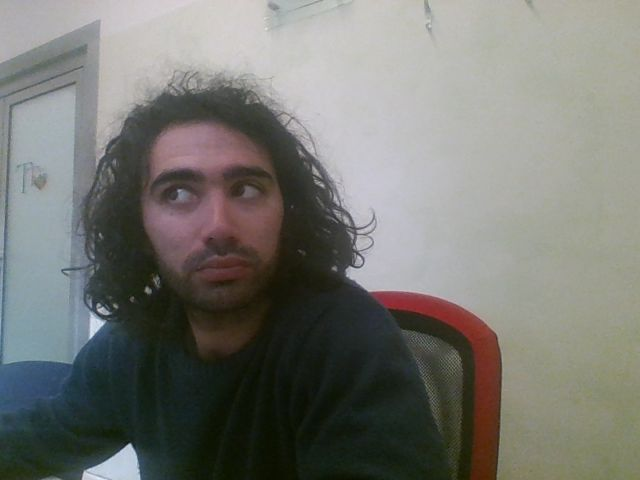

In [3]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Run detection Model

In [8]:
%%capture
!pip install ultralytics

In [29]:
# ------------------------------
# Run inference real time locally
# -----------------------------
# pip install ultralytics

import numpy as np
from ultralytics import YOLO
import cv2
import torch
import time
from PIL import Image

class Yolov8Inference:
    def __init__(self, path_to_model, gpu=False):
        self.device = torch.device("cpu")
        if gpu and torch.cuda.is_available():
            self.device = torch.device("cuda")
        self.model = YOLO(path_to_model).to(self.device)
    def run(self, im_list, conf_thres=0.01, iou_thres=0.01):
        start = time.time()
        res = self.model.predict(im_list, imgsz=640, device=self.device, conf=conf_thres, iou=iou_thres, verbose=False)
        end = time.time()
        print(f"Elapsed: {np.round(end-start,3)}s")
        if not isinstance(im_list, list):
            im_list = [im_list]
        im_draw_list = []
        for i in range(0, len(res)):
            im_draw = im_list[i].copy()
            names = res[i].names
            scores = res[i].boxes.conf.cpu().numpy()
            class_ids = res[i].boxes.cls.cpu().numpy()
            boxes = res[i].boxes.xyxy.cpu().numpy()
            for box, score, class_id in zip(boxes, scores, class_ids):
                x1, y1, x2, y2 = box.astype(int)
                cv2.rectangle(im_draw, (x1, y1), (x2, y2), (0, 255, 0), 1)
                cv2.putText(im_draw, f"{names[class_id]}: {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            im_draw_list.append(im_draw)
        return im_draw_list


Elapsed: 0.401s


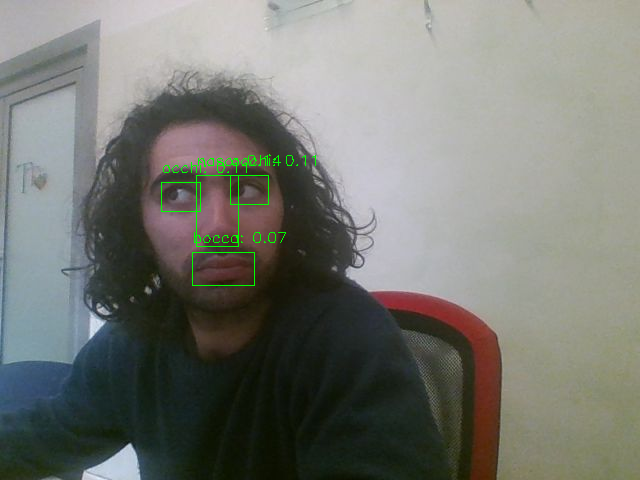

In [30]:
# Read Image
im = cv2.imread("photo.jpg", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Load Model
#model = Yolov8Inference("yolov8n.pt")
model = Yolov8Inference("occhi-naso-bocca.pt")

# Inference
im_draw_list = model.run(im)
for im_draw in im_draw_list:
    display(Image.fromarray(im_draw))

## Locale example runtime

```python
# ------------------------------
# Run inference real time locally
# -----------------------------
# pip install ultralytics

import numpy as np
from ultralytics import YOLO
import cv2

class Yolov8Inference:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.labels = self.model.names
    def predict(self, im):
        res = self.model.predict(im, imgsz=640, conf=0.05, iou=0.05, verbose=False)
        im_draw = im.copy()
        names = res[0].names
        scores = res[0].boxes.conf.cpu().numpy()
        class_ids = res[0].boxes.cls.cpu().numpy()
        boxes = res[0].boxes.xyxy.cpu().numpy()
        for box, score, class_id in zip(boxes, scores, class_ids):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(im_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(im_draw, f"{names[class_id]}: {score:.2f}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return im_draw

# Load Model
model = Yolov8Inference("models/manuel_occhi_naso_bocca.pt")

cap = cv2.VideoCapture(0)
while True:
    # Read the current frame from the camera
    ret, frame = cap.read()

    im_draw = model.predict(frame)

    if ret:
        # Display the frame
        cv2.imshow("Camera", im_draw)

        # Check if the 'q' key is pressed to exit the loop
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
```